In [1]:
# Gain modulation RNN with oja learning on weight matrix, nonlinear lqg
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from rnn import RNN
import json
from torch.autograd.functional import jacobian
from torch import tensor
import torch
import torch.nn as nn
import scipy.linalg as sp_linalg

## Loading Trained Weights

In [2]:
with open('../weights/MacheyGlass_oja_60_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 10000 #ms
num_inputs = 1
num_nodes = 60
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

# define inputs and targets
dt = network.timestep/network.time_const
T = np.arange(0, 1000)

def generate_MackeyGlass(ntimes, tau):
    # initial condition
    # x_values = np.random.uniform(0,1,tau).tolist()
    x_values = [0.1]*tau

    def mackey_glass(x, tau, gamma=0.1, beta0=0.2, n=10):
        dxdt = beta0 * x[-tau] / (1 + x[-tau]**n) - gamma * x[-1]
        return dxdt

    x_t = x_values[-1]
    for t in range(ntimes):
        dxdt = mackey_glass(x_values, tau)
        x_t = x_t + dxdt
        x_values.append(x_t)

    x = x_values[tau:]
    return x

total_time_steps = 1000
tau = 20
MG_sequence = np.array(generate_MackeyGlass(total_time_steps+1, tau))
inputs = MG_sequence[0:total_time_steps].reshape(-1,1)
targets = MG_sequence[1:total_time_steps+1].reshape(-1,1)

In [6]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 1000/1000 [00:00<00:00, 13482.82it/s]


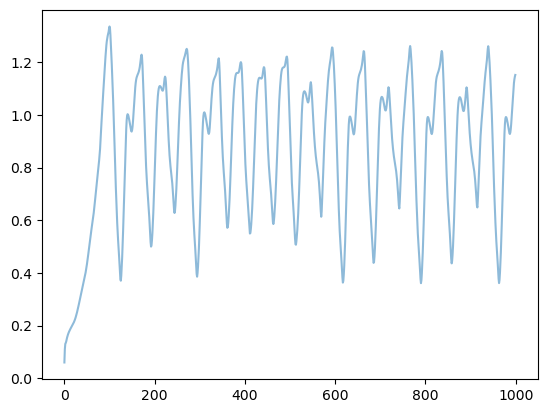

In [7]:
plt.plot(T, outputs.detach().numpy(), alpha=0.5, label='simu')

In [8]:
# estimate period
values = outputs.detach().numpy()
values_tolast = values[1:total_time_steps-1] - values[0:-2] < 0
values_tonext = values[1:total_time_steps-1] - values[2:] < 0
values_belowmid = values[1:total_time_steps-1] < 0.8
troughs = np.where(values_tolast * values_tonext * values_belowmid)[0]
period = np.mean(np.diff(troughs)).round()
period # estimated to be 56

56.0

## Manual Simulatation

In [9]:
# System Description
def f_tensor(x_tensor, u_tensor):
    gains_tensor = tensor(gains)
    weights_tensor = tensor(weight_matrix)
    shifts_tensor = tensor(shifts)
    activation_func = nn.Sigmoid()
    y_tensor = (1 - dt) * x_tensor + dt * activation_func(gains_tensor * (torch.matmul(weights_tensor, x_tensor) + u_tensor - shifts_tensor))
    return y_tensor

def f(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    y_tensor = f_tensor(x_tensor, u_tensor)
    y = y_tensor.numpy()
    return y

def jacob(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    dydx, dydu = jacobian(f_tensor,(x_tensor, u_tensor))
    Jx_tensor = dydx.squeeze(dim=(1,3))
    Ju_tensor = dydu.squeeze(dim=(1,3))
    Jx = Jx_tensor.numpy()
    Ju = Ju_tensor.numpy()
    return Jx, Ju

In [10]:
# define matrices
c = np.eye(num_nodes)
Bnoise = np.eye(num_nodes)
W = np.eye(num_nodes) * 0.001
V = np.eye(num_nodes) * 0.001
Q = np.eye(num_nodes) * 1
R = np.eye(num_nodes) * 0.01

# define noise
np.random.seed(42)
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=W, size=len(T))).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=V, size=len(T))).T
# x_noises[:,0:50] = 0
# x_noises[:,50:60] += 0.1
# x_noises[:,60:150] = 0
# x_noises[:,150:160] += 0.1
# x_noises[:,160:300] = 0
# x_noises *= 0
noise_time = np.arange(100, 1000, int(period))
for t in noise_time:
    x_noises[:,t:t+5] += 0.05

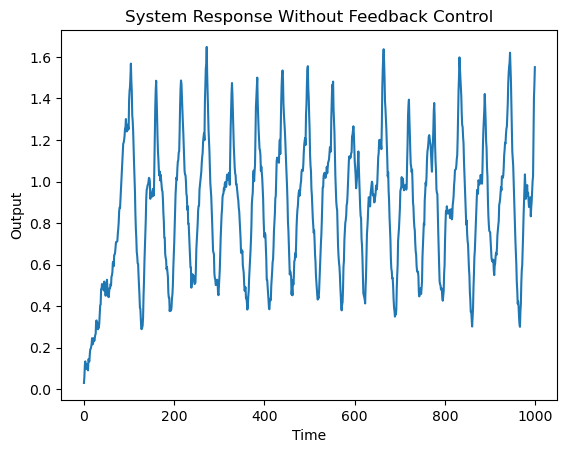

In [11]:
# Simulation Without Control
x = init_activations.copy()
u = init_activations.copy()
xs = []
ys = []
outputs_o = []

for i in T:
    
    # update x
    this_input = inputs[i] * input_weights.T
    u = this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    output = output_weight_matrix @ x
    
    # save
    xs.append(x)
    ys.append(y)
    outputs_o.append(output.item())

# Plot the output
plt.plot(T, outputs_o)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

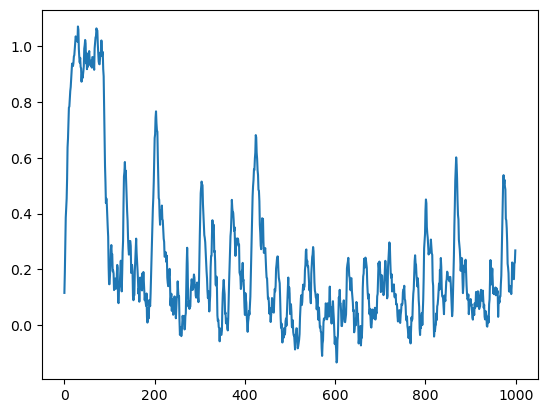

In [12]:
x1s = [x[0].item() for x in xs]
plt.plot(T, x1s)
plt.show()

### Non-linear LQG

/scratch/users/jinbeige/conda/envs/rnn/lib/python3.8/site-packages/scipy/linalg/_basic.py:1564: RuntimeWarning: invalid value encountered in cast
  ps = ps.astype(int, copy=False) - 1


0.0008840986196333145
0.001038927908133888
0.0005486870823403029
0.0010243239380470358
0.0002338184285700059
0.00017807293235864774
3.22844829329213e-05
0.0004906155025280765
3.0243058364391413e-05
0.00011057402712006824
0.0002432974101536212
0.0
0.0006412840878463276
8.028025847643038e-06
0.0005695096815804937
0.00011477600780950589
0.0005309810779583687
0.00011403013263096096
0.0004505657726707097
0.00012328272643462142
0.0003833077483719764
0.0003304679743820509
1.069882049667591e-169
0.0006854016497456699
2.501162089628585e-05
2.9682283683901234e-05
0.0001336324901238858
0.0008165075371563773
0.00021121409337262814
0.0008917583874927199
0.0002314472199636483
0.0005934332757951856
0.00046702326537616636
0.0007246087087840855
0.0005039569708866297
0.0003460415323350415
0.00039637422944076035
0.0005102379907093364
0.00031910118595717627
4.5931005866143025e-06
0.000516160553170206
0.00010215744386213409
0.0012014114789768025
0.00010448602476014168
0.0010574806765129357
0.00025599520459

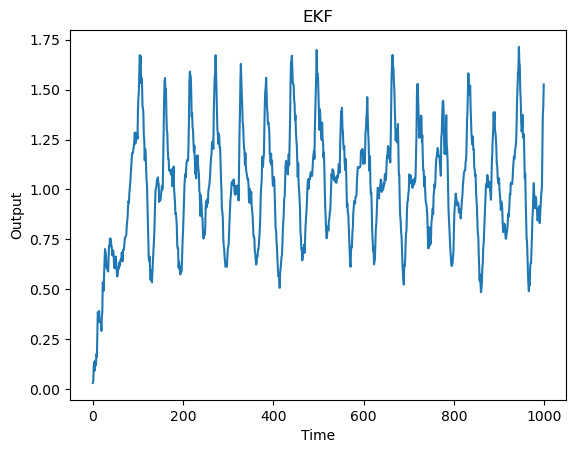

In [16]:
ideal_activations = activations.detach().numpy()
x = init_activations.copy()
u = init_activations.copy()
xhat = init_activations.copy()
Phat = W.copy()
xs = []
ys = []
ctrlus = []
xhats = []
outputs_b = []

for i in T:

    # Update x
    this_input = inputs[i] * input_weights.T
    u = u + this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    measurement_noise = y_noises[:,i].reshape(-1,1)
    y = c @ x + measurement_noise
    output = output_weight_matrix @ x

    # Save
    xs.append(x)
    ys.append(y)
    outputs_b.append(output.item())

    # Kalman
    xpred = f(xhat, u)
    F, _ = jacob(xhat, u)
    Ppred = F @ Phat @ F.T + W
    ypred = c @ xpred

    S = c @ Ppred @ c.T + V
    Kf = Ppred @ c.T @ np.linalg.inv(S)

    xhat = xpred + Kf @ (y - ypred)
    phat = Ppred - Kf @ c @ Ppred
    yres = y - c @ xhat

    xhats.append(xhat)

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    A, B = jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    print(np.mean(np.abs(B)))
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    u = -K @ (xhat - this_ideal_activation)
    # if np.mean(u**2) > 10:
    #     u *= 0
    ctrlus.append(u)
    # print(np.mean(u**2))

# Plot the state
# outputhats = [(output_weight_matrix @ x).item() for x in xhats]
plt.plot(T, outputs_b)
# plt.plot(T, outputs_o)
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('EKF')
plt.show()

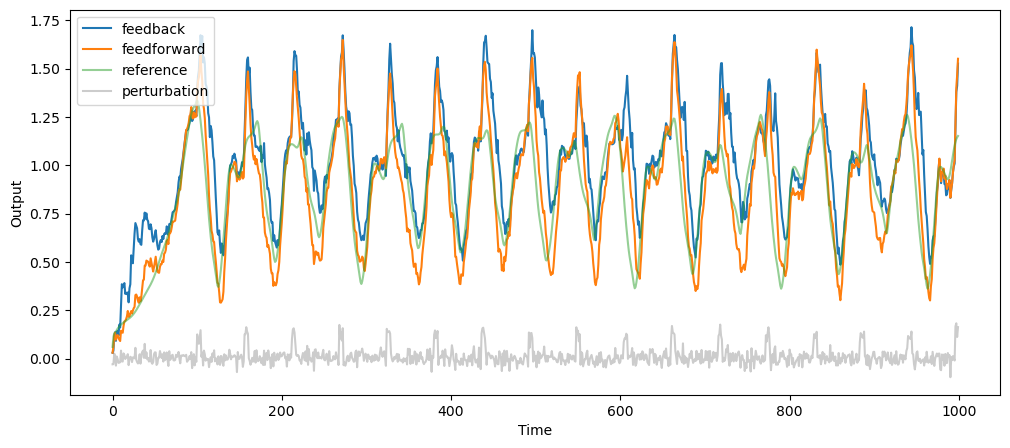

In [14]:
noises_out = (output_weight_matrix @ x_noises).squeeze()

plt.subplots(figsize=(12,5))
plt.plot(T, outputs_b, label='feedback')
plt.plot(T, outputs_o, label='feedforward')
plt.plot(T, outputs.detach().numpy(), alpha=0.5, label='reference')
plt.plot(T, noises_out, alpha=0.2, color='black', label='perturbation')
plt.xlabel('Time')
plt.ylabel('Output')
# plt.title('LQG')
plt.legend()
plt.savefig("fig/MG_oja_lqg.png")

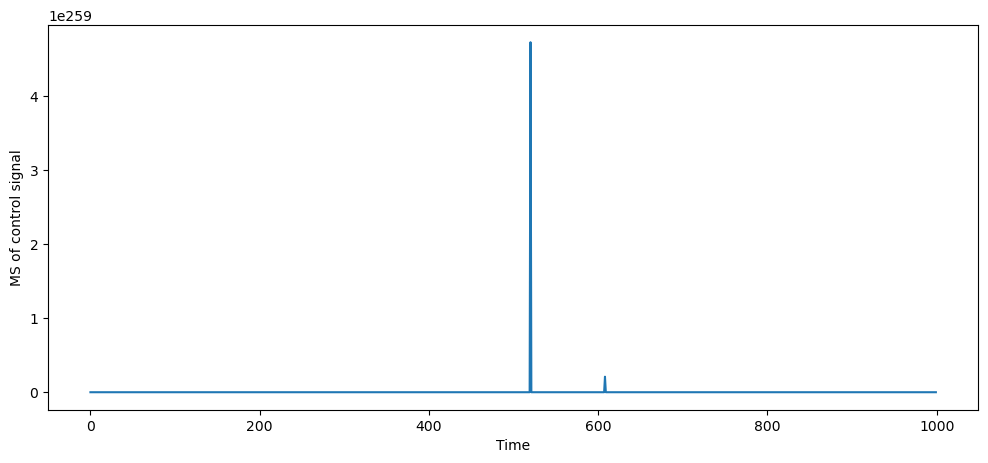

In [15]:
plt.subplots(figsize=(12,5))
umeans = [np.mean(u**2).item() for u in ctrlus]
plt.plot(T, umeans)
plt.xlabel('Time')
plt.ylabel('MS of control signal')
plt.savefig("fig/MG_oja_lqg_umean.pdf")